# TB CODA

In [2]:
import math
import random
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib
import glob
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# seed value for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [3]:
def find_label(participant):
    return clinical_data['tb_status'][clinical_data['participant']==participant].to_list()[0] 

In [4]:
clinical_data = pd.read_csv("Clinical_Meta.csv")
metadata_solicited = pd.read_csv("Solicited_Meta.csv")
metadata_solicited

,participant,filename,sound_prediction_score
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039
...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813


In [5]:
label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
metadata_solicited['label'] = label
metadata_solicited['relative_path'] = 'solicited/' + metadata_solicited['filename']

# add all other colums from clinical data to metadata 
for col in clinical_data.columns:
    if col not in metadata_solicited.columns:
        metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())

# print columns
print(metadata_solicited.columns)

/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_29207/3789096686.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_29207/3789096686.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())
/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_29207/3789096686.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` i

Index(['participant', 'filename', 'sound_prediction_score', 'label',
       'relative_path', 'sex', 'age', 'height', 'weight', 'reported_cough_dur',
       'tb_prior', 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown',
       'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
       'fever', 'night_sweats', 'tb_status'],
      dtype='object')


/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_29207/3789096686.py:8: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())


In [6]:
metadata_solicited['sex'] = metadata_solicited['sex'].map({'Male': 0, 'Female': 1})
metadata_solicited['tb_prior'] = metadata_solicited['tb_prior'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Pul'] = metadata_solicited['tb_prior_Pul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Extrapul'] = metadata_solicited['tb_prior_Extrapul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Unknown'] = metadata_solicited['tb_prior_Unknown'].map({'No': 0, 'Yes': 1})
metadata_solicited['hemoptysis'] = metadata_solicited['hemoptysis'].map({'No': 0, 'Yes': 1})
metadata_solicited['weight_loss'] = metadata_solicited['weight_loss'].map({'No': 0, 'Yes': 1})
metadata_solicited['smoke_lweek'] = metadata_solicited['smoke_lweek'].map({'No': 0, 'Yes': 1})
metadata_solicited['fever'] = metadata_solicited['fever'].map({'No': 0, 'Yes': 1})
metadata_solicited['night_sweats'] = metadata_solicited['night_sweats'].map({'No': 0, 'Yes': 1})

# count number of NaN values
print(metadata_solicited.isnull().sum())


participant                0
filename                   0
sound_prediction_score     0
label                      0
relative_path              0
sex                        0
age                        0
height                    23
weight                     0
reported_cough_dur         0
tb_prior                  23
tb_prior_Pul               0
tb_prior_Extrapul          0
tb_prior_Unknown           0
hemoptysis                 0
heart_rate                 0
temperature                0
weight_loss                0
smoke_lweek                0
fever                      0
night_sweats               0
tb_status                  0
dtype: int64


In [7]:
# drop NaN values
metadata_solicited = metadata_solicited.dropna()

metadata_solicited.head()


,participant,filename,sound_prediction_score,label,relative_path,sex,age,height,weight,reported_cough_dur,...,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats,tb_status
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0,solicited/1645088710003-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0,solicited/1645088760390-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0,solicited/1645088760830-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0,solicited/1645088710843-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0,solicited/1645088759950-recording-1.wav,0,27,173.3,63.0,30,...,0,0,0,99,37.2,1,0,1,1,0


In [8]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
import matplotlib.pyplot as plt
from tqdm import tqdm

segmented_files_tbcoda = []

# Create a progress bar
progress_bar = tqdm(metadata_solicited['filename'], total=len(metadata_solicited['filename']))

for file_path in progress_bar:
    audio_file = '/Users/sudac/Downloads/UofA/solicited/' + file_path
    x, fs = librosa.load(audio_file, sr=None)

    # Segment the cough
    cough_segments, cough_mask = segment_cough(x, fs, cough_padding=0.055, min_cough_len=.005)

    # Save segmented audio files
    output_dir = '/Users/sudac/Downloads/UofA/solicited/Audio_files_segmented/'
    os.makedirs(output_dir, exist_ok=True)

    for i, segment in enumerate(cough_segments):
        segment_file = os.path.join(output_dir, f"{file_path}")
        sf.write(segment_file, segment, fs)  # Using soundfile to write the audio file
        # Retrieve additional information from tbscreen DataFrame
        class_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'label'].values[0]
        gndr_a_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'sex'].values[0]
        age_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'age'].values[0]
        subject_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'participant'].values[0]
        # Append segmented file information to segmented_files list
        segmented_files_tbcoda.append({
            'filename': f"{file_path}",
            'label': class_value,
            'sex': gndr_a_value,
            'age': age_value,
            'participant': subject_value
        })

    # Update the progress bar description
    progress_bar.set_postfix(file=file_path)



segmented_df_coda = pd.DataFrame(segmented_files_tbcoda)
print(len(segmented_df_coda))

100%|██████████| 9726/9726 [00:42<00:00, 226.39it/s, file=1658213974948-recording-1.wav]


7506


In [9]:
segmented_df_coda['participant'].value_counts()

participant
CODA_TB_0973    40
CODA_TB_0244    39
CODA_TB_0878    35
CODA_TB_0766    32
CODA_TB_0129    30
                ..
CODA_TB_0721     1
CODA_TB_0975     1
CODA_TB_0972     1
CODA_TB_0119     1
CODA_TB_0883     1
Name: count, Length: 1061, dtype: int64

In [10]:
positive_patients = segmented_df_coda[segmented_df_coda['label'] == 1]['participant'].unique()
positive_patients_count = len(positive_patients)

negative_patients = segmented_df_coda[segmented_df_coda['label'] == 0]['participant'].unique()
negative_patients_count = len(negative_patients)

print("Number of unique positive patients:", positive_patients_count)
print("Number of unique negative patients:", negative_patients_count)


Number of unique positive patients: 284
Number of unique negative patients: 777


In [11]:
label_0_count = (segmented_df_coda[segmented_df_coda['label'] == 0]['participant']
                 .value_counts()
                 .loc[lambda x: x <= 3]
                 .count())

label_1_count = (segmented_df_coda[segmented_df_coda['label'] == 1]['participant']
                 .value_counts()
                 .loc[lambda x: x <= 3]
                 .count())

print("Number of patients with TB status 0 and 2 or fewer cough segments:", label_0_count)
print("Number of patients with TB status 1 and 2 or fewer cough segments:", label_1_count)


Number of patients with TB status 0 and 2 or fewer cough segments: 170
Number of patients with TB status 1 and 2 or fewer cough segments: 61


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Get unique participant IDs and their counts
participants_counts = segmented_df_coda['participant'].value_counts()

# Initialize empty DataFrames for train and test
df_train = pd.DataFrame()
df_test = pd.DataFrame()

# Determine the number of participants for each split (adjust ratio as needed)
train_participants, test_participants = train_test_split(participants_counts.index, test_size=0.2, random_state=42)


# Filter data based on the selected participants
df_train = segmented_df_coda[segmented_df_coda['participant'].isin(train_participants)]
df_test = segmented_df_coda[segmented_df_coda['participant'].isin(test_participants)]

# Double-check to ensure participants are only in one split
assert set(df_train['participant'].unique()) & set(df_test['participant'].unique()) == set()


In [13]:
# check which split participant a certian patient is in
participant_id = 'CODA_TB_0001'

if df_train['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the train set')
if df_test['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the test set')


CODA_TB_0001 is in the train set


In [14]:
df_train['label'].value_counts()

label
0    4120
1    1809
Name: count, dtype: int64

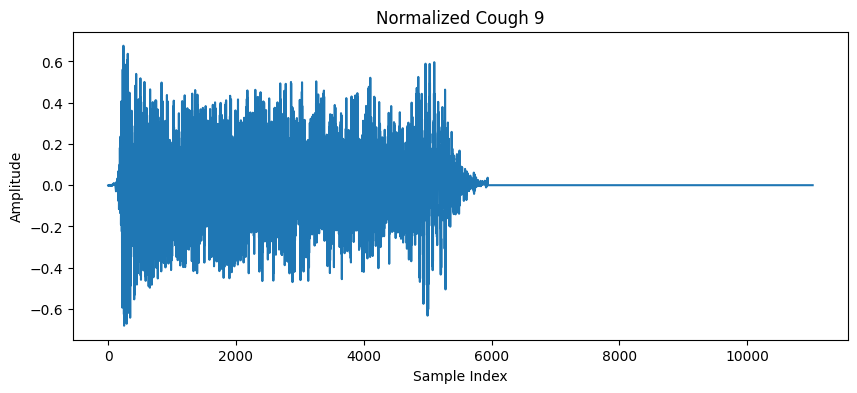

In [15]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
from tqdm import tqdm  # Import tqdm

def normalize_cough_duration(segmented_df_coda_train, target_duration_ms=500, fs=22050):
    normalized_coughs_train = []
    for index, row in segmented_df_coda_train.iterrows():
        # Load the cough audio data
        file_path = row['filename']
        audio_file = '/Users/sudac/Downloads/UofA/solicited/Audio_files_segmented/' + file_path
        cough_data, _ = librosa.load(audio_file, sr=fs)

        # Calculate the target length in samples
        target_length = int(target_duration_ms / 1000 * fs)

        # Pad or trim the audio signal
        if len(cough_data) < target_length:
            # Zero-pad the signal
            padded_signal = np.pad(cough_data, (0, target_length - len(cough_data)), 'constant')
            normalized_coughs_train.append(padded_signal)
        else:
            # Trim the signal
            trimmed_signal = cough_data[:target_length]
            normalized_coughs_train.append(trimmed_signal)

    return normalized_coughs_train

def visualize_normalized_cough(normalized_coughs_train, index):
    if index >= len(normalized_coughs_train):
        print(f"Invalid index: {index}. Index should be between 0 and {len(normalized_coughs_train) - 1}.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_coughs_train[index])
    plt.title(f"Normalized Cough {index}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
normalized_coughs_tbcoda_train = normalize_cough_duration(df_train, target_duration_ms=500, fs=22050)
visualize_normalized_cough(normalized_coughs_tbcoda_train, 9)  


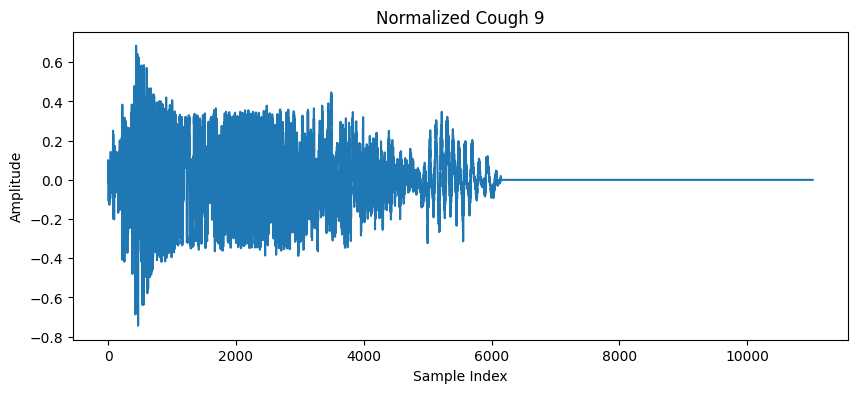

In [16]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
from tqdm import tqdm  # Import tqdm

import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
import matplotlib.pyplot as plt

def normalize_cough_duration(segmented_df_coda_test, target_duration_ms=500, fs=22050):
    normalized_coughs_test = []
    for index, row in segmented_df_coda_test.iterrows():
        # Load the cough audio data
        file_path = row['filename']
        audio_file = '/Users/sudac/Downloads/UofA/solicited/Audio_files_segmented/' + file_path
        cough_data, _ = librosa.load(audio_file, sr=fs)

        # Calculate the target length in samples
        target_length = int(target_duration_ms / 1000 * fs)

        # Pad or trim the audio signal
        if len(cough_data) < target_length:
            # Zero-pad the signal
            padded_signal = np.pad(cough_data, (0, target_length - len(cough_data)), 'constant')
            normalized_coughs_test.append(padded_signal)
        else:
            # Trim the signal
            trimmed_signal = cough_data[:target_length]
            normalized_coughs_test.append(trimmed_signal)

    return normalized_coughs_test

def visualize_normalized_cough(normalized_coughs_test, index):
    if index >= len(normalized_coughs_test):
        print(f"Invalid index: {index}. Index should be between 0 and {len(normalized_coughs_test) - 1}.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_coughs_test[index])
    plt.title(f"Normalized Cough {index}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
normalized_coughs_tbcoda_test = normalize_cough_duration(df_test, target_duration_ms=500, fs=22050)
visualize_normalized_cough(normalized_coughs_tbcoda_test, 9)  


In [17]:
import librosa
import numpy as np

def calc_mel_spectrogram(y, sr = 22050, n_fft = 2048, hop_length = 512, n_mels=128):
    spect = librosa.feature.melspectrogram(y=y, n_fft=n_fft, sr=sr, hop_length=hop_length, n_mels = n_mels)
    return librosa.power_to_db(spect, ref=np.max)

In [18]:
# Calculate mel spectrograms
mel_spectrogram_train = np.array([calc_mel_spectrogram(y, 22050) for y in normalized_coughs_tbcoda_train])
mel_spectrogram_test = np.array([calc_mel_spectrogram(y, 22050) for y in normalized_coughs_tbcoda_test])
print(mel_spectrogram_train.shape, mel_spectrogram_test.shape)

(5929, 128, 22) (1577, 128, 22)


# TB Screen

In [19]:
# opene TBscreen TBscreen/Forced coughs.csv
tbscreen = pd.read_csv('TBscreen/Forced coughs.csv')

# reorder the rows with  'gndr_a', 'age', 'prev_tb', 'extrapulmo_tb', 'cough_bld', 'un_wght_loss', 'smoke_lweek', 'fever', 'nght_swts'
tbscreen = tbscreen[['path', 'subject', 'class', 'gndr_a', 'age']]

print(tbscreen['subject'].nunique())

# remove rows with NaN values
tbscreen = tbscreen.dropna()

# print class ratio of class
tbscreen['class'].value_counts()

# print number of unique subjects
tbscreen['subject'].nunique()

50


47

In [20]:
tbscreen

,path,subject,class,gndr_a,age
0,PID_175A_0_codec,PID_175A,1.0,0.0,36.0
1,PID_175A_0_pixel,PID_175A,1.0,0.0,36.0
2,PID_175A0_yeti,PID_175A,1.0,0.0,36.0
3,PID_175A_1_codec,PID_175A,1.0,0.0,36.0
4,PID_175A_1_pixel,PID_175A,1.0,0.0,36.0
...,...,...,...,...,...
1200,PID_199A_now_C_19_codec,PID_199A_now_C,0.0,1.0,60.0
1201,PID_199A_now_C_20_codec,PID_199A_now_C,0.0,1.0,60.0
1202,PID_199A_now_C_22_yeti,PID_199A_now_C,0.0,1.0,60.0
1203,PID_199A_now_C_23_yeti,PID_199A_now_C,0.0,1.0,60.0


In [21]:
# drop the row with in any part of filename
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_183A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_192A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_198A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_207A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_218A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_224A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_225A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_78C')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_199A')]

In [22]:
# print class ratio of class
tbscreen['class'].value_counts()

class
1.0    825
0.0    143
Name: count, dtype: int64

In [23]:
# print number of unique subjects
tbscreen['subject'].nunique()

38

In [24]:
y, sr = librosa.load('/Users/sudac/Downloads/UofA/TBscreen/Audio_files/PID_73C_0_pixel.wav')
print(y.shape, sr)


(22050,) 22050


In [25]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
from tqdm import tqdm  # Import tqdm

# Assuming you have a DataFrame named 'tbscreen' with columns 'path' and 'class'

segmented_files_tbscreen = []

# Create a progress bar
progress_bar = tqdm(tbscreen['path'], total=len(tbscreen['path']))

for file_path in progress_bar:
    audio_file = '/Users/sudac/Downloads/UofA/TBscreen/Audio_files/' + file_path + '.wav'
    x, fs = librosa.load(audio_file, sr=None)

    # Segment the cough
    cough_segments, cough_mask = segment_cough(x, fs, cough_padding=0.05, min_cough_len=.01)

    # Save segmented audio files
    output_dir = '/Users/sudac/Downloads/UofA/TBscreen/Audio_files_segmented/'
    os.makedirs(output_dir, exist_ok=True)

    for i, segment in enumerate(cough_segments):
        segment_file = os.path.join(output_dir, f"{file_path}_{i}.wav")
        sf.write(segment_file, segment, fs)  # Using soundfile to write the audio file
        # Retrieve additional information from tbscreen DataFrame
        class_value = tbscreen.loc[tbscreen['path'] == file_path, 'class'].values[0]
        gndr_a_value = tbscreen.loc[tbscreen['path'] == file_path, 'gndr_a'].values[0]
        age_value = tbscreen.loc[tbscreen['path'] == file_path, 'age'].values[0]
        subject_value = tbscreen.loc[tbscreen['path'] == file_path, 'subject'].values[0]
        # Append segmented file information to segmented_files list
        segmented_files_tbscreen.append({
            'path': f"{file_path}_{i}.wav",
            'class': class_value,
            'gndr_a': gndr_a_value,
            'age': age_value,
            'subject': subject_value
        })

    # Update the progress bar description
    progress_bar.set_postfix(file=file_path)



segmented_df_tbscreen = pd.DataFrame(segmented_files_tbscreen)


  0%|          | 0/968 [00:00<?, ?it/s, file=PID_175A_1_codec]

100%|██████████| 968/968 [00:07<00:00, 129.26it/s, file=PID_82C_9_codec]    


In [26]:
segmented_df_tbscreen

,path,class,gndr_a,age,subject
0,PID_175A_0_codec_0.wav,1.0,0.0,36.0,PID_175A
1,PID_175A_0_pixel_0.wav,1.0,0.0,36.0,PID_175A
2,PID_175A0_yeti_0.wav,1.0,0.0,36.0,PID_175A
3,PID_175A_1_codec_0.wav,1.0,0.0,36.0,PID_175A
4,PID_175A_1_pixel_0.wav,1.0,0.0,36.0,PID_175A
...,...,...,...,...,...
953,PID_82C_7_codec_0.wav,0.0,1.0,25.0,PID_82C
954,PID_82C_8_pixel_0.wav,0.0,1.0,25.0,PID_82C
955,PID_82C_8_codec_0.wav,0.0,1.0,25.0,PID_82C
956,PID_82C_9_pixel_0.wav,0.0,1.0,25.0,PID_82C


In [27]:
positive_patients = segmented_df_tbscreen[segmented_df_tbscreen['class'] == 1]['subject'].unique()
positive_patients_count = len(positive_patients)

negative_patients = segmented_df_tbscreen[segmented_df_tbscreen['class'] == 0]['class'].unique()
negative_patients_count = len(negative_patients)

print("Number of unique positive patients:", positive_patients_count)
print("Number of unique negative patients:", negative_patients_count)


Number of unique positive patients: 34
Number of unique negative patients: 1


In [28]:
label_0_count = (segmented_df_tbscreen[segmented_df_tbscreen['class'] == 0]['class']
                 .value_counts()
                 .loc[lambda x: x <= 4]
                 .count())

label_1_count = (segmented_df_tbscreen[segmented_df_tbscreen['class'] == 1]['class']
                 .value_counts()
                 .loc[lambda x: x <= 4]
                 .count())

print("Number of patients with TB status 0 and 2 or fewer cough segments:", label_0_count)
print("Number of patients with TB status 1 and 2 or fewer cough segments:", label_1_count)


Number of patients with TB status 0 and 2 or fewer cough segments: 0
Number of patients with TB status 1 and 2 or fewer cough segments: 0


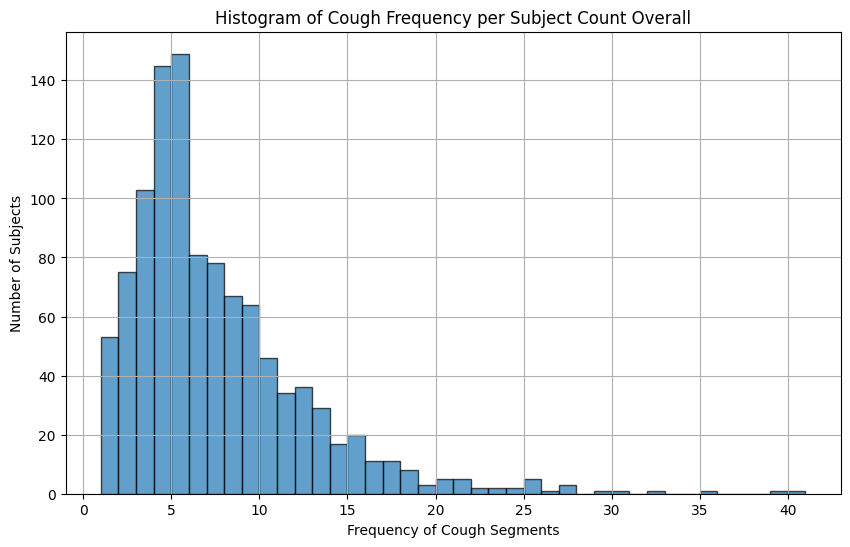

In [29]:
import matplotlib.pyplot as plt

subject_counts = segmented_df_coda['participant'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(subject_counts, bins=range(1, subject_counts.max() + 2), edgecolor='black', alpha=0.7)

plt.xlabel('Frequency of Cough Segments')
plt.ylabel('Number of Subjects')
plt.title('Histogram of Cough Frequency per Subject Count Overall')

plt.grid(True)
plt.show()


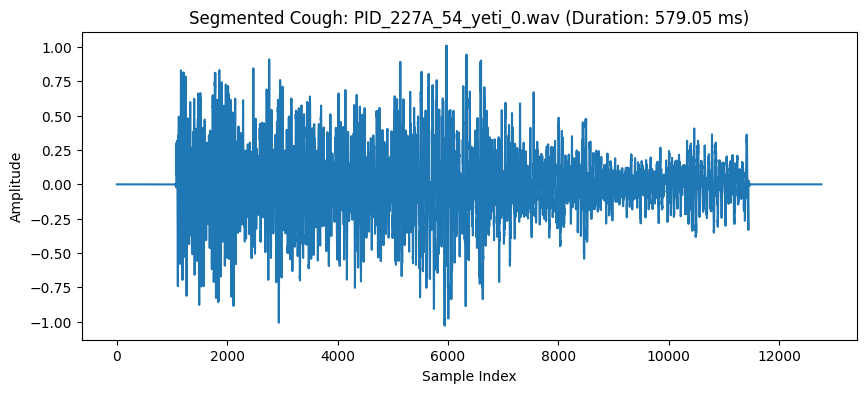

In [30]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
import matplotlib.pyplot as plt


def visualize_cough(segmented_df_tbscreen, index, fs):
    # Get the file path and load the audio data
    file_path = segmented_df_tbscreen.loc[index, 'path']
    audio_file = '/Users/sudac/Downloads/UofA/TBscreen/Audio_files_segmented/' + file_path
    cough_data, _ = librosa.load(audio_file, sr=fs)

    # Calculate the duration in milliseconds
    duration_ms = len(cough_data) / fs * 1000

    # Visualize the cough segment
    plt.figure(figsize=(10, 4))
    plt.plot(cough_data)
    plt.title(f"Segmented Cough: {file_path} (Duration: {duration_ms:.2f} ms)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
visualize_cough(segmented_df_tbscreen, 696, 22050)

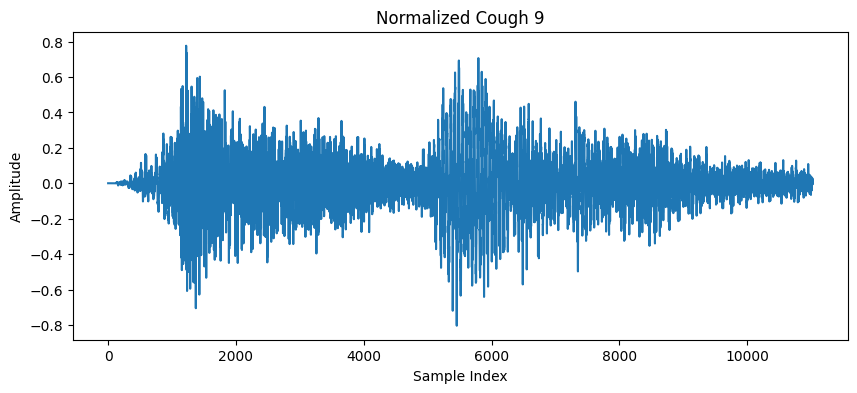

In [31]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
import matplotlib.pyplot as plt

def normalize_cough_duration(segmented_df_tbscreen, target_duration_ms=500, fs=22050):
    normalized_coughs_tbscreen = []
    for index, row in segmented_df_tbscreen.iterrows():
        # Load the cough audio data
        file_path = row['path']
        audio_file = '/Users/sudac/Downloads/UofA/TBscreen/Audio_files_segmented/' + file_path
        cough_data, _ = librosa.load(audio_file, sr=fs)

        # Calculate the target length in samples
        target_length = int(target_duration_ms / 1000 * fs)

        # Pad or trim the audio signal
        if len(cough_data) < target_length:
            # Zero-pad the signal
            padded_signal = np.pad(cough_data, (0, target_length - len(cough_data)), 'constant')
            normalized_coughs_tbscreen.append(padded_signal)
        else:
            # Trim the signal
            trimmed_signal = cough_data[:target_length]
            normalized_coughs_tbscreen.append(trimmed_signal)

    return normalized_coughs_tbscreen

def visualize_normalized_cough(normalized_coughs_tbscreen, index):
    if index >= len(normalized_coughs_tbscreen):
        print(f"Invalid index: {index}. Index should be between 0 and {len(normalized_coughs_tbscreen) - 1}.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_coughs_tbscreen[index])
    plt.title(f"Normalized Cough {index}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
normalized_coughs_tbscreen = normalize_cough_duration(segmented_df_tbscreen, target_duration_ms=500, fs=22050)
visualize_normalized_cough(normalized_coughs_tbscreen, 9)  



In [32]:
# from segmentation import segment_cough

# # Assuming the sample rate is 22050 Hz
# fs = 22050

# for i, audio_signal in enumerate(normalized_coughs_tbscreen):
#     # Segment the cough
#     cough_segments, cough_mask = segment_cough(audio_signal, fs, cough_padding=0.01)

#     # Visualize the segmentation output
#     plt.figure(figsize=(12, 4))
#     plt.plot(audio_signal)
#     plt.plot(cough_mask)
#     plt.title(f'Segmentation Output for Audio Signal {i}')
#     plt.xlabel('Sample Index')
#     plt.ylabel('Amplitude')
#     plt.legend(['Audio Signal', 'Cough Mask'])
#     plt.show()

#     # Print the length of the audio signal in milliseconds
#     audio_length_ms = len(audio_signal) / fs * 1000
#     print(f"Length of the audio signal {i}: {audio_length_ms:.2f} ms")

#     # Print the length of each cough segment in milliseconds
#     for j, cough_segment in enumerate(cough_segments):
#         cough_length_ms = len(cough_segment) / fs * 1000
#         print(f"Length of cough segment {j} in audio signal {i}: {cough_length_ms:.2f} ms")

#     print('-' * 40)

In [33]:
mel_spectrogram_tbscreeen = np.array([calc_mel_spectrogram(y, sr) for y in normalized_coughs_tbscreen])

In [34]:
X_tabular_tbscreen  = segmented_df_tbscreen.drop(['path', 'class', 'subject'], axis=1).values
y_tbscreen = segmented_df_tbscreen['class']
X_mel_tbscreen = np.expand_dims(mel_spectrogram_tbscreeen, -1)
print(X_mel_tbscreen.shape)


(958, 128, 22, 1)


# Train

In [35]:
df_test

,filename,label,sex,age,participant
138,1636618802577-recording-1.wav,0,1,52,CODA_TB_0026
139,1636618801697-recording-1.wav,0,1,52,CODA_TB_0026
140,1636618782705-recording-1.wav,0,1,52,CODA_TB_0026
141,1636618723908-recording-1.wav,0,1,52,CODA_TB_0026
142,1636618741434-recording-1.wav,0,1,52,CODA_TB_0026
...,...,...,...,...,...
7496,1640314233142-recording-1.wav,1,1,63,CODA_TB_1106
7497,1640314232582-recording-1.wav,1,1,63,CODA_TB_1106
7498,1640314213990-recording-1.wav,1,1,63,CODA_TB_1106
7499,1640314212030-recording-1.wav,1,1,63,CODA_TB_1106


In [36]:
# print null values
print(df_train.isnull().sum())

filename       0
label          0
sex            0
age            0
participant    0
dtype: int64


In [37]:
# Tabular data
X_tabular_train = df_train.drop(['participant', 'filename', 'label'], axis=1).values  

X_tabular_test  = df_test.drop(['participant', 'filename', 'label'], axis=1).values

# Labels
y_train = df_train['label']
y_test = df_test['label']

# Mel spectrogram data
X_mel_train = np.expand_dims(mel_spectrogram_train, -1)
X_mel_test = np.expand_dims(mel_spectrogram_test, -1)


In [38]:
print(X_mel_train.shape)

(5929, 128, 22, 1)


In [39]:
print(df_test.drop(['participant', 'filename', 'label'], axis=1).columns)

Index(['sex', 'age'], dtype='object')


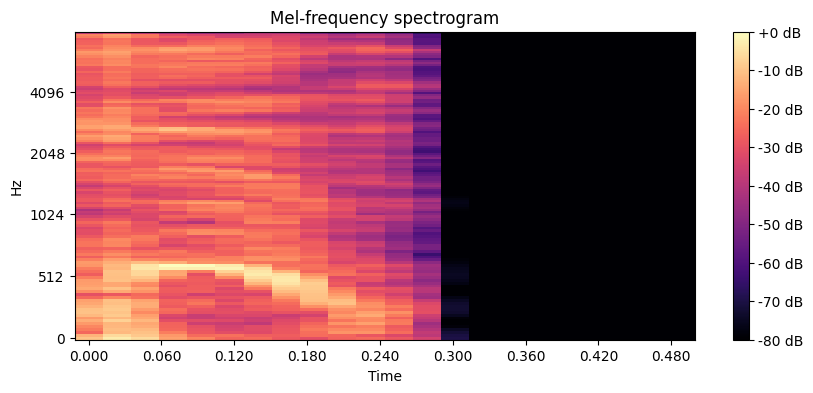

In [40]:
# display audio file with axis labels 
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_train[0], x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.show()

In [41]:
# input shapes
mel_input_shape = X_mel_train.shape[1:]  
tabular_input_shape = X_tabular_train.shape[1]

In [42]:
print(X_tabular_test.shape[1])

2


In [43]:
from tensorflow.keras import layers, models

# Gated Activation Unit (GAU)
def gated_activation_unit(x):
    tanh_out = layers.Activation('tanh')(x)
    sigmoid_out = layers.Activation('sigmoid')(x)
    return layers.Multiply()([tanh_out, sigmoid_out])

# Multi-Head Self-Attention
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, heads, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0

        self.depth = self.d_model // self.heads

        self.query_dense = layers.Dense(self.d_model)
        self.key_dense = layers.Dense(self.d_model)
        self.value_dense = layers.Dense(self.d_model)

        self.combine_heads = layers.Dense(self.d_model)

    def call(self, inputs, **kwargs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split the heads
        query = layers.Reshape((self.heads, self.depth))(query)
        key = layers.Reshape((self.heads, self.depth))(key)
        value = layers.Reshape((self.heads, self.depth))(value)

        # Apply scaled dot-product attention
        attention = layers.Attention()([query, key, value])
        attention = layers.Reshape((self.d_model,))(attention)

        # Combine heads
        output = self.combine_heads(attention)
        return output

# Model architecture
mel_input = layers.Input(shape=mel_input_shape, name='mel_input')
x = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(mel_input)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = gated_activation_unit(x)

# Tabular input
tabular_input = layers.Input(shape=(tabular_input_shape,), name='tabular_input')
y = layers.Dense(1024)(tabular_input)
y = layers.Dense(256)(tabular_input)
y = layers.Dropout(0.15)(y)

# Multi-Head Self-Attention
attention = MultiHeadSelfAttention(heads=8)(x)
weighted_x = layers.Multiply()([x, attention])

# Concatenate the paths
combined = layers.Concatenate()([weighted_x, y])

# Dense layers for final classification
z = layers.Dense(512, activation='leaky_relu')(combined)
z = layers.LayerNormalization()(z)
z = layers.Dense(256, activation='leaky_relu')(z)
z = layers.Dropout(0.15)(z)
output = layers.Dense(1, activation='sigmoid', name='output')(z)

# Create the model
model = models.Model(inputs={'mel_input': mel_input, 'tabular_input': tabular_input}, outputs=output)

model.summary()

2024-05-14 11:27:13.272878: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-14 11:27:13.272978: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-14 11:27:13.272989: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-14 11:27:13.273418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-14 11:27:13.273861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mel_input (InputLayer)      [(None, 128, 22, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 22, 64)          640       ['mel_input[0][0]']           
                                                                                                  
 layer_normalization (Layer  (None, 128, 22, 64)          128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 11, 64)           0         ['layer_normalization[0][0

In [44]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def focal_loss(y_true, y_pred, alpha=0.65, gamma=2):
    # Calculate the focal loss
    ce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    fl_loss = alpha * tf.pow(1 - pt, gamma) * ce_loss
    return fl_loss

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def s_plus_s(y_true, y_pred):
    return sensitivity(y_true, y_pred) + specificity(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=focal_loss,
    metrics=['accuracy', 'AUC']
)


In [45]:
EPOCHS = 100

try:
    history = model.fit(
        {'mel_input': X_mel_train, 'tabular_input':  X_tabular_train}, y_train,
        epochs=EPOCHS,
        validation_data=({'mel_input': X_mel_test, 'tabular_input':  X_tabular_test}, y_test),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=5, mode='max', restore_best_weights=True),
        ]
    )
except KeyboardInterrupt:
    print("Training interrupted manually.")


Epoch 1/100


2024-05-14 11:27:14.698964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-14 11:27:14.833374: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


186/186 [==============================] - 11s 51ms/step - loss: 0.0904 - accuracy: 0.6844 - auc: 0.5466 - val_loss: 0.0861 - val_accuracy: 0.7020 - val_auc: 0.5874
Epoch 2/100
186/186 [==============================] - 8s 45ms/step - loss: 0.0857 - accuracy: 0.6932 - auc: 0.5776 - val_loss: 0.0898 - val_accuracy: 0.6588 - val_auc: 0.5890
Epoch 3/100
186/186 [==============================] - 9s 46ms/step - loss: 0.0844 - accuracy: 0.6929 - auc: 0.5904 - val_loss: 0.0858 - val_accuracy: 0.7039 - val_auc: 0.6029
Epoch 4/100
186/186 [==============================] - 8s 45ms/step - loss: 0.0841 - accuracy: 0.6851 - auc: 0.5946 - val_loss: 0.1209 - val_accuracy: 0.5948 - val_auc: 0.6022
Epoch 5/100
186/186 [==============================] - 8s 45ms/step - loss: 0.0827 - accuracy: 0.6858 - auc: 0.6090 - val_loss: 0.0925 - val_accuracy: 0.7349 - val_auc: 0.6119
Epoch 6/100
186/186 [==============================] - 9s 46ms/step - loss: 0.0819 - accuracy: 0.6925 - auc: 0.6129 - val_loss: 0.0

In [59]:
# Register the custom layer with keras.utils.custom_object_scope
tf.keras.utils.get_custom_objects()['MultiHeadSelfAttention'] = MultiHeadSelfAttention
tf.keras.utils.get_custom_objects()['focal_loss'] = focal_loss
model.save("TB_model_path.h5")

In [ ]:
import tensorflow as tf
import gradio as gr
import numpy as np
import librosa

# Load the pre-trained model
model = tf.keras.models.load_model('TB_model_path.h5')

# Define a mapping dictionary for gender
gender_map = {"Male": 0, "Female": 1}

def calc_mel_spectrogram(y, sr=22050, n_fft=2048, hop_length=512, n_mels=128):
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    return librosa.power_to_db(spect, ref=np.max(spect))

def predict_single_audio(audio_file, gender, age):
    # Load audio file
    sample_rate, audio_data = audio_file
    # Shorten audio data to 11025 samples
    audio_data = audio_data[:11025]
    # Convert audio data to floating-point format
    audio_data = audio_data.astype(np.float32)
    # Calculate mel spectrogram
    mel_spectrogram = calc_mel_spectrogram(audio_data, sr=sample_rate)
    # Reshape mel spectrogram to match expected input shape (1, time_steps, n_mels, 1)
    mel_spectrogram = mel_spectrogram.reshape(1, mel_spectrogram.shape[0], mel_spectrogram.shape[1], 1)
    # Convert gender to numerical value
    gender_value = gender_map[gender]
    # Predict
    prediction = model.predict({'mel_input': mel_spectrogram, 'tabular_input': np.array([[gender_value, age]])})
    predicted_label = "TB positive with probability of " + str(prediction) if prediction > 0.5 else "TB negative with a probability of " + str(prediction)
    return predicted_label  # Return the predicted label as an integer

# Create Gradio interface
audio_input = gr.Audio(label="Upload your audio file")
gender_input = gr.Radio(["Male", "Female"], label="Gender")
age_input = gr.Number(label="Age")

gr.Interface(
    fn=predict_single_audio, 
    inputs=[audio_input, gender_input, age_input], 
    outputs="label", 
    title="Detection of TB via Acoustics",
    description="By Chandra Suda"
).launch(share=True)

Running on local URL:  http://127.0.0.1:7895
Running on public URL: https://0d94ac57dbafd8c2d2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 79ms/step


In [52]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict({'mel_input': X_mel_test, 'tabular_input':  X_tabular_test})
roc_auc = roc_auc_score(y_test, y_pred)

# add probability to df_test using .loc
df_test.loc[:, 'probability'] = y_pred

# save df_test to csv
df_test.to_csv('solicited-audio-test.csv', index=False)

roc_auc

50/50 [==============================] - 1s 18ms/step


/var/folders/7q/m4xnvvz54q5bmp4svjrhzn8wyyhlpq/T/ipykernel_29207/2315214286.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'probability'] = y_pred


0.7291469712794812

Max Metrics:
AUC: 0.7063239308462239


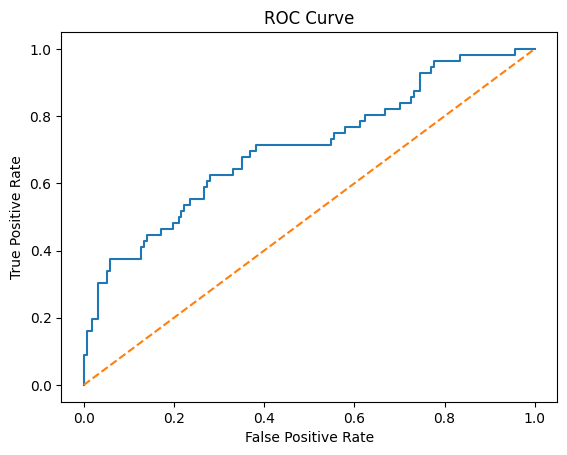

Threshold value is: 0.4266319
Sensitivity: 0.625
Specificity: 0.7197452229299364


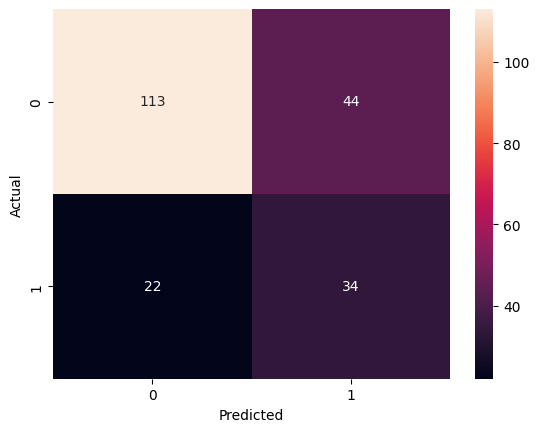

              precision    recall  f1-score   support

       No TB       0.84      0.72      0.77       157
          TB       0.44      0.61      0.51        56

    accuracy                           0.69       213
   macro avg       0.64      0.66      0.64       213
weighted avg       0.73      0.69      0.70       213

Specificity at 90% sensitivity: [0.25477707]
Median Metrics:
AUC: 0.7222474977252047


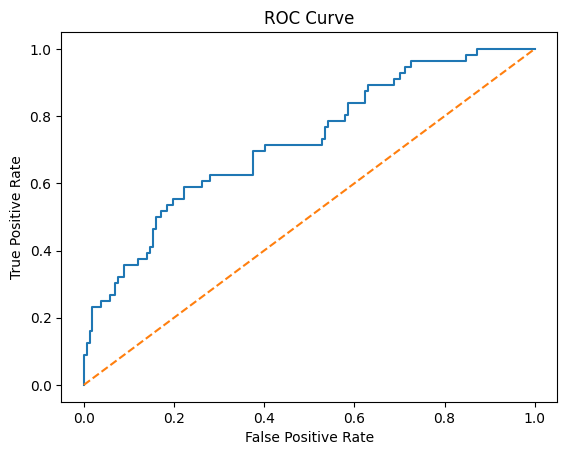

Threshold value is: 0.3403551
Sensitivity: 0.5892857142857143
Specificity: 0.7770700636942676


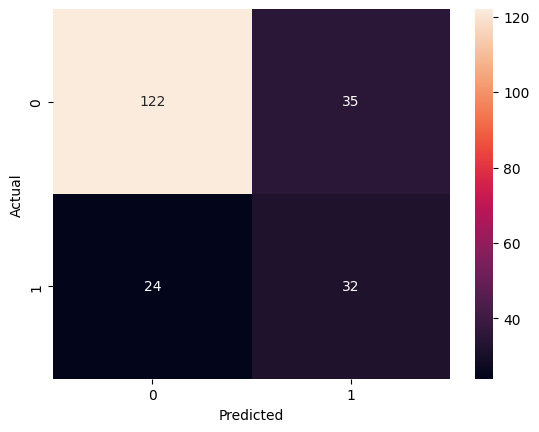

              precision    recall  f1-score   support

       No TB       0.84      0.78      0.81       157
          TB       0.48      0.57      0.52        56

    accuracy                           0.72       213
   macro avg       0.66      0.67      0.66       213
weighted avg       0.74      0.72      0.73       213

Specificity at 90% sensitivity: [0.31210191]
Mean Metrics:
AUC: 0.7203139217470427


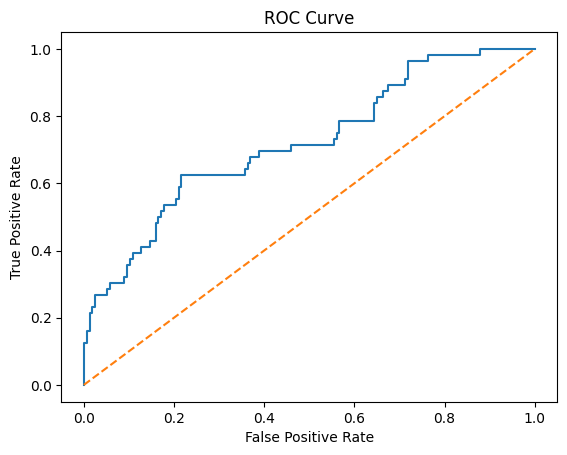

Threshold value is: 0.3459043
Sensitivity: 0.625
Specificity: 0.7834394904458599


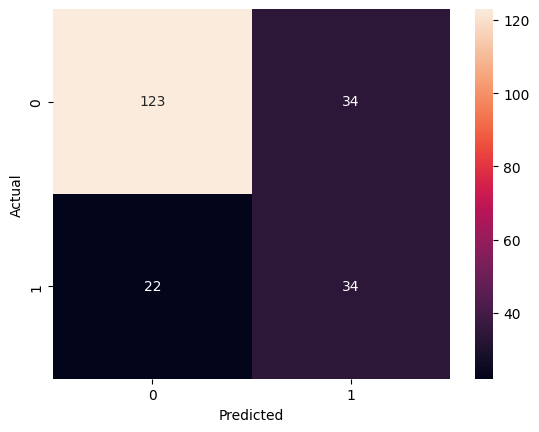

              precision    recall  f1-score   support

       No TB       0.85      0.78      0.81       157
          TB       0.50      0.61      0.55        56

    accuracy                           0.74       213
   macro avg       0.67      0.70      0.68       213
weighted avg       0.76      0.74      0.74       213

Specificity at 90% sensitivity: [0.2866242]
Min Metrics:
AUC: 0.737943585077343


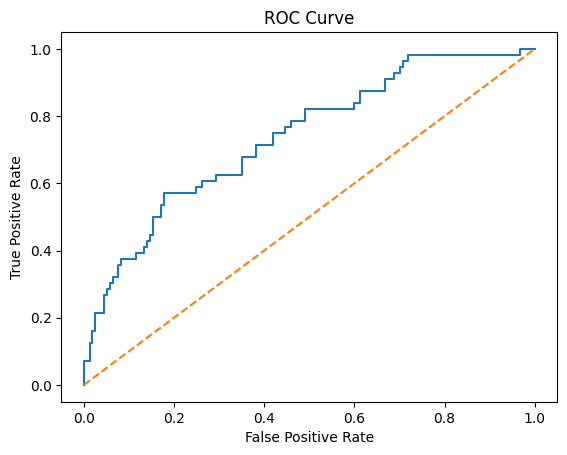

Threshold value is: 0.27701762
Sensitivity: 0.5714285714285714
Specificity: 0.821656050955414


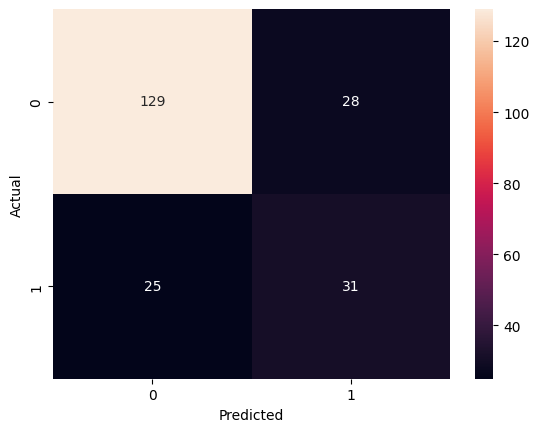

              precision    recall  f1-score   support

       No TB       0.84      0.82      0.83       157
          TB       0.53      0.55      0.54        56

    accuracy                           0.75       213
   macro avg       0.68      0.69      0.68       213
weighted avg       0.76      0.75      0.75       213

Specificity at 90% sensitivity: [0.33121019]
75th Percentile Metrics:
AUC: 0.7039353958143767


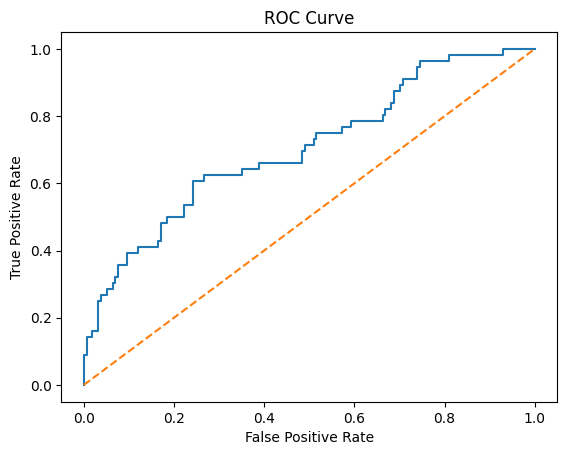

Threshold value is: 0.37627143412828445
Sensitivity: 0.6071428571428571
Specificity: 0.7579617834394905


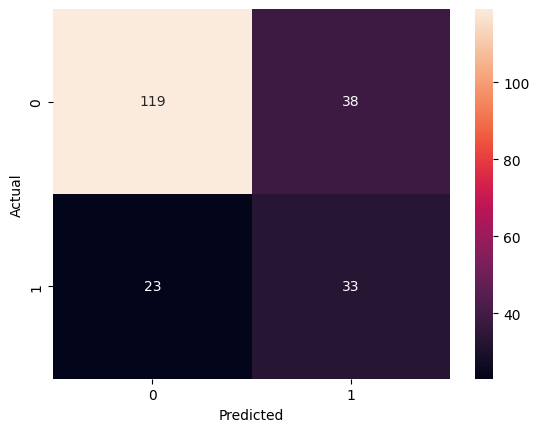

              precision    recall  f1-score   support

       No TB       0.84      0.76      0.80       157
          TB       0.46      0.59      0.52        56

    accuracy                           0.71       213
   macro avg       0.65      0.67      0.66       213
weighted avg       0.74      0.71      0.72       213

Specificity at 90% sensitivity: [0.29299363]


In [53]:
def calculate_metrics():
    roc_auc_score(df['label'], df['probability'])

    # print auc  and auc curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(df['label'], df['probability'])
    print("AUC:", roc_auc_score(df['label'], df['probability']))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    print("Sensitivity:", tpr[optimal_idx])
    print("Specificity:", 1 - fpr[optimal_idx])

    # print the optimal confusion matrix using seaborn
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    y_pred_2 = np.where(df['probability'] > optimal_threshold, 1, 0)
    cm = confusion_matrix(df['label'], y_pred_2)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # print classification report
    from sklearn.metrics import classification_report
    target_names = ['No TB', 'TB']
    print(classification_report(df['label'], y_pred_2, target_names=target_names))

    # get the specificity when the sensitivity is 0.90
    sensitivity = 0.90
    idx = np.argwhere(np.diff(np.sign(tpr - sensitivity))).flatten()
    specificity = 1 - fpr[idx]
    print("Specificity at 90% sensitivity:", specificity)


df_test.loc[:, 'probability'] = y_pred

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].max()
df.to_csv('Max-Predictions.csv', index=False)
print("Max Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].median()
df.to_csv('Median-Predictions.csv', index=False)
print("Median Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].mean()
df.to_csv('Mean-Predictions.csv', index=False)
print("Mean Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].min()
df.to_csv('Min-Predictions.csv', index=False)
print("Min Metrics:")
calculate_metrics()
df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].quantile(.75)
df.to_csv('75th-Percentile-Predictions.csv', index=False)
print("75th Percentile Metrics:")
calculate_metrics()



In [ ]:
# import librosa
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming df_test is already defined with 'relative_path', 'probability', 'label' columns

# # Function to calculate audio length
# def calculate_audio_length(x):
#     return len(librosa.load(x)[0])

# # Calculate audio length for each file in the test set
# df_test['audio_length'] = df_test['relative_path'].apply(calculate_audio_length)

# # Assuming 'label' is the true label (0 or 1) and 'probability' is the predicted probability
# # Calculate accuracy for different threshold values
# threshold_values = np.linspace(0, 1, 100)
# accuracies = []

# for threshold in threshold_values:
#     predicted_labels = (df_test['probability'] >= threshold).astype(int)
#     accuracy = (predicted_labels == df_test['tb_status']).mean()
#     accuracies.append(accuracy)

# # Find the optimal threshold with maximum accuracy
# optimal_threshold = threshold_values[np.argmax(accuracies)]

# # Calculate accuracy with the optimal threshold
# optimal_predicted_labels = (df_test['probability'] >= optimal_threshold).astype(int)
# df_test['predicted_label'] = optimal_predicted_labels  # Add predicted labels to DataFrame
# optimal_accuracy = (optimal_predicted_labels == df_test['tb_status']).mean()

# # Calculate correlation between audio length and predicted label
# correlation = df_test['audio_length'].corr(df_test['predicted_label'])

# # Scatter plot with probabilities as colors
# plt.scatter(df_test['audio_length'], df_test['predicted_label'], c=df_test['probability'], cmap='viridis', label='Predicted Label')
# plt.axvline(x=df_test['audio_length'].mean(), color='r', linestyle='--', label='Mean Audio Length')
# plt.xlabel('Audio Length')
# plt.ylabel('Predicted Label')
# plt.title('Audio Length vs Predicted Label (Color-coded by Probability)')
# plt.colorbar(label='Probability')
# plt.legend()
# plt.show()

# # Print results
# print(f"Correlation between audio length and predicted label: {correlation}")
# print(f"Optimal Threshold for Maximum Accuracy: {optimal_threshold}")
# print(f"Accuracy with Optimal Threshold: {optimal_accuracy}")


30/30 [==============================] - 1s 20ms/step
AUC: 0.5500836120401338


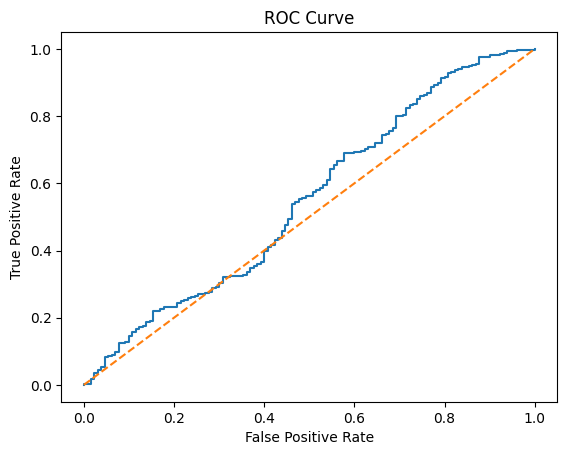

Threshold value is: 0.05281012
Sensitivity: 0.9142512077294686
Specificity: 0.20769230769230773


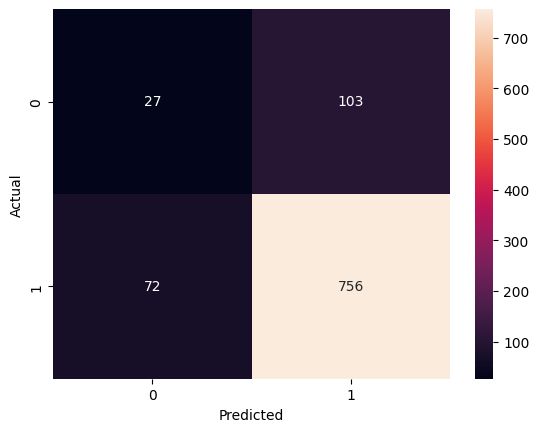

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict({'mel_input': X_mel_tbscreen, 'tabular_input':  X_tabular_tbscreen})
roc_auc = roc_auc_score(y_tbscreen, y_pred)

# add probability to df_test using .loc
segmented_df_tbscreen.loc[:, 'probability'] = y_pred

# save df_test to csv
segmented_df_tbscreen.to_csv('solicited-audio-test.csv', index=False)

roc_auc

# also add print sensitivty and specifit on optimal threshold
# print auc  and auc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(segmented_df_tbscreen['class'], segmented_df_tbscreen['probability'])
print("AUC:", roc_auc_score(segmented_df_tbscreen['class'], segmented_df_tbscreen['probability']))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
print("Sensitivity:", tpr[optimal_idx])
print("Specificity:", 1 - fpr[optimal_idx])

# print the optimal confusion matrix using seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred_2 = np.where(segmented_df_tbscreen['probability'] > optimal_threshold, 1, 0)
cm = confusion_matrix(segmented_df_tbscreen['class'], y_pred_2)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Max Metrics:
AUC: 0.4632352941176471


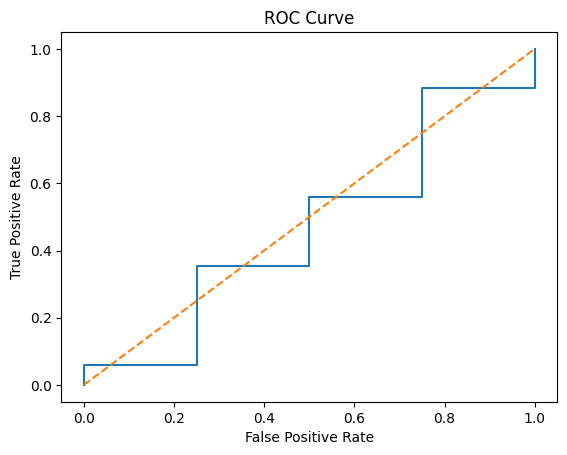

Threshold value is: 0.21382421
Sensitivity: 0.8823529411764706
Specificity: 0.25


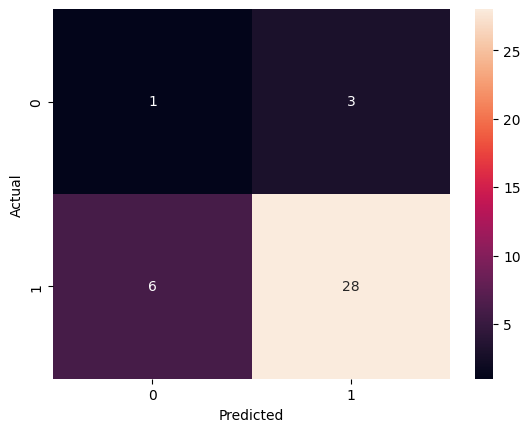

              precision    recall  f1-score   support

       No TB       0.14      0.25      0.18         4
          TB       0.90      0.82      0.86        34

    accuracy                           0.76        38
   macro avg       0.52      0.54      0.52        38
weighted avg       0.82      0.76      0.79        38

Specificity at 75% sensitivity: [0.25]
Median Metrics:
AUC: 0.7647058823529411


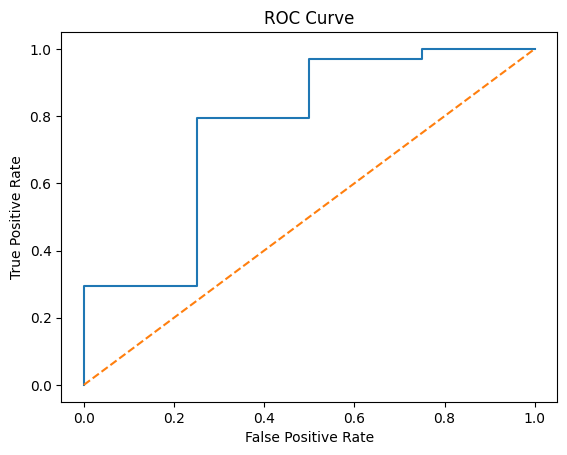

Threshold value is: 0.21382421
Sensitivity: 0.7941176470588235
Specificity: 0.75


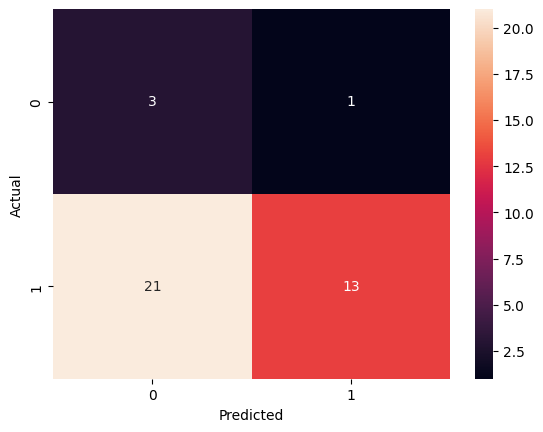

              precision    recall  f1-score   support

       No TB       0.12      0.75      0.21         4
          TB       0.93      0.38      0.54        34

    accuracy                           0.42        38
   macro avg       0.53      0.57      0.38        38
weighted avg       0.84      0.42      0.51        38

Specificity at 75% sensitivity: [0.75]
Mean Metrics:
AUC: 0.6691176470588236


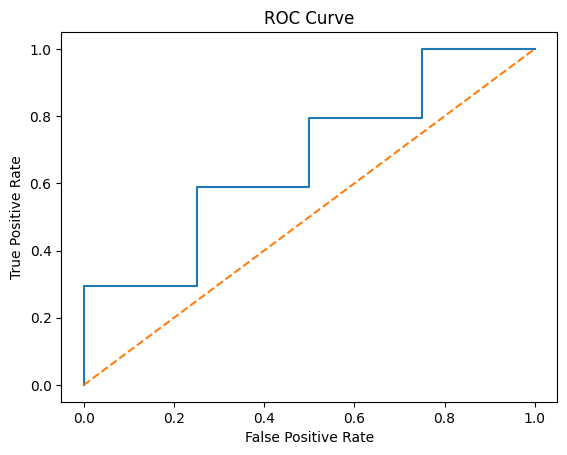

Threshold value is: 0.21382421
Sensitivity: 0.5882352941176471
Specificity: 0.75


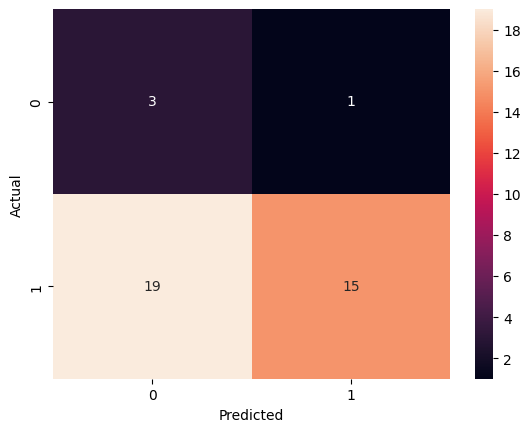

              precision    recall  f1-score   support

       No TB       0.14      0.75      0.23         4
          TB       0.94      0.44      0.60        34

    accuracy                           0.47        38
   macro avg       0.54      0.60      0.42        38
weighted avg       0.85      0.47      0.56        38

Specificity at 75% sensitivity: [0.5]
Min Metrics:
AUC: 0.8014705882352942


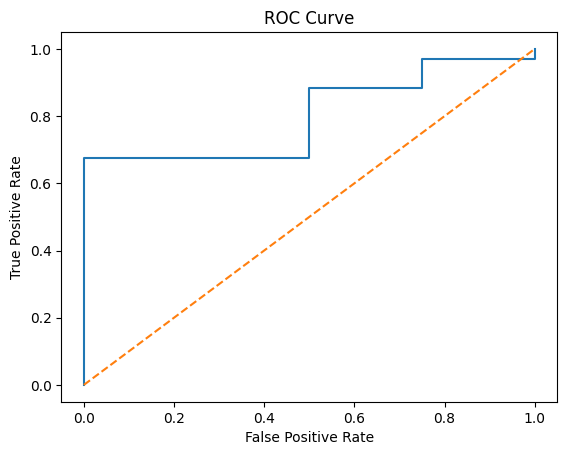

Threshold value is: 0.21382421
Sensitivity: 0.6764705882352942
Specificity: 1.0


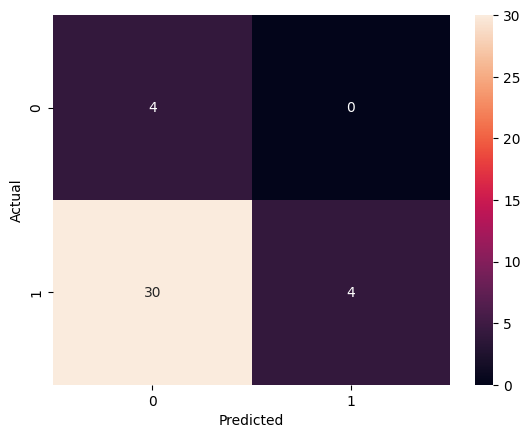

              precision    recall  f1-score   support

       No TB       0.12      1.00      0.21         4
          TB       1.00      0.12      0.21        34

    accuracy                           0.21        38
   macro avg       0.56      0.56      0.21        38
weighted avg       0.91      0.21      0.21        38

Specificity at 75% sensitivity: [0.5]
90th Percentile Metrics:
AUC: 0.5514705882352942


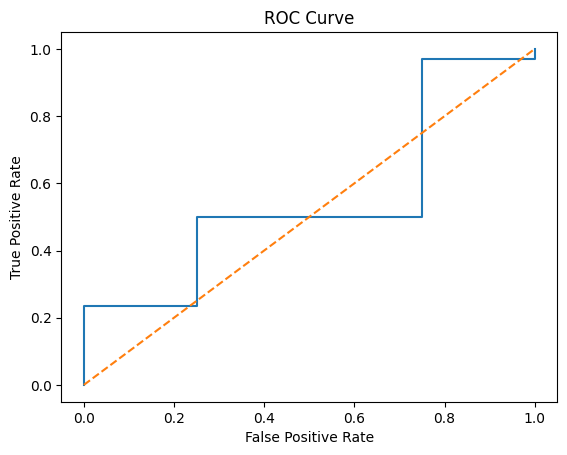

Threshold value is: 0.21382421
Sensitivity: 0.5
Specificity: 0.75


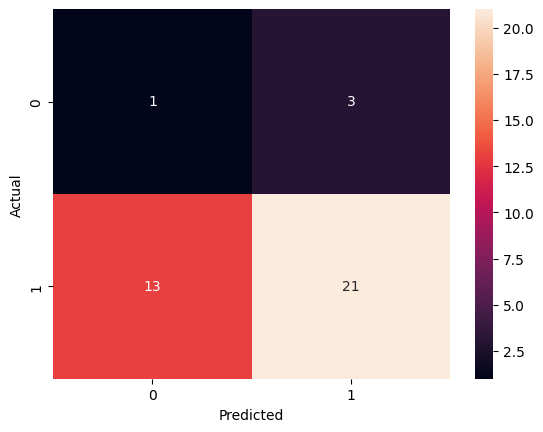

              precision    recall  f1-score   support

       No TB       0.07      0.25      0.11         4
          TB       0.88      0.62      0.72        34

    accuracy                           0.58        38
   macro avg       0.47      0.43      0.42        38
weighted avg       0.79      0.58      0.66        38

Specificity at 75% sensitivity: [0.25]


In [ ]:
def calculate_metrics():
    roc_auc_score(df['class'], df['probability'])

    # print auc  and auc curve
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(df['class'], df['probability'])
    print("AUC:", roc_auc_score(df['class'], df['probability']))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr - fpr)
    # optimal_threshold = thresholds[optimal_idx]
    optimal_threshold = 0.21382421
    print("Threshold value is:", optimal_threshold)
    print("Sensitivity:", tpr[optimal_idx])
    print("Specificity:", 1 - fpr[optimal_idx])


    # print the optimal confusion matrix using seaborn
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    y_pred_2 = np.where(df['probability'] > optimal_threshold, 1, 0)
    cm = confusion_matrix(df['class'], y_pred_2)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # print classification report
    from sklearn.metrics import classification_report
    target_names = ['No TB', 'TB']
    print(classification_report(df['class'], y_pred_2, target_names=target_names))

    # get the specificity when the sensitivity is 0.90
    sensitivity = 0.75
    idx = np.argwhere(np.diff(np.sign(tpr - sensitivity))).flatten()
    specificity = 1 - fpr[idx]
    print("Specificity at 75% sensitivity:", specificity)


segmented_df_tbscreen.loc[:, 'probability'] = y_pred

df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].max()
df.to_csv('Max-Predictions.csv', index=False)
print("Max Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].median()
df.to_csv('Median-Predictions.csv', index=False)
print("Median Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].mean()
df.to_csv('Mean-Predictions.csv', index=False)
print("Mean Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].min()
df.to_csv('Min-Predictions.csv', index=False)
print("Min Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].quantile(.9)
df.to_csv('90th-Percentile-Predictions.csv', index=False)
print("90th Percentile Metrics:")
calculate_metrics()


In [ ]:
# from sklearn.inspection import permutation_importance
# from sklearn.metrics import accuracy_score
# import numpy as np
# import matplotlib.pyplot as plt

# # Get the feature names
# feature_names = df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status'], axis=1).columns
# print(feature_names)

# def wrapper_predict(X):
#     return model.predict([X_mel_train, X])

# def keras_accuracy(estimator, X, y_true):
#     y_pred = estimator.predict(X)
#     return accuracy_score(y_true, np.round(y_pred))

# class KerasWrapper:
#     def __init__(self, model):
#         self.model = model

#     def fit(self, X, y):
#         self.model.fit(X, y)

#     def predict(self, X):
#         return wrapper_predict(X)

# # Create a wrapped model
# wrapped_model = KerasWrapper(model)

# # Use the wrapped model with permutation_importance
# result = permutation_importance(wrapped_model, X_tabular_train, y_train, scoring=keras_accuracy, n_repeats=2, random_state=42, n_jobs=1)

# # Sort the features by importance
# sorted_idx = result.importances_mean.argsort()

# # Plot the permutation importances
# fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=np.array(feature_names)[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()

